Original shape: (303, 14)
After dropping duplicates: (302, 14)

=== Model Evaluation Metrics ===
              Metric    Value
            Accuracy 0.852459
Sensitivity (Recall) 0.843750
           Precision 0.870968
            F1 Score 0.857143
         Specificity 0.862069
           AUC Score 0.929957


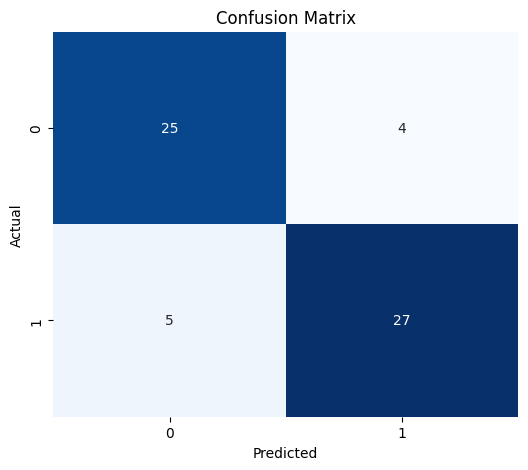

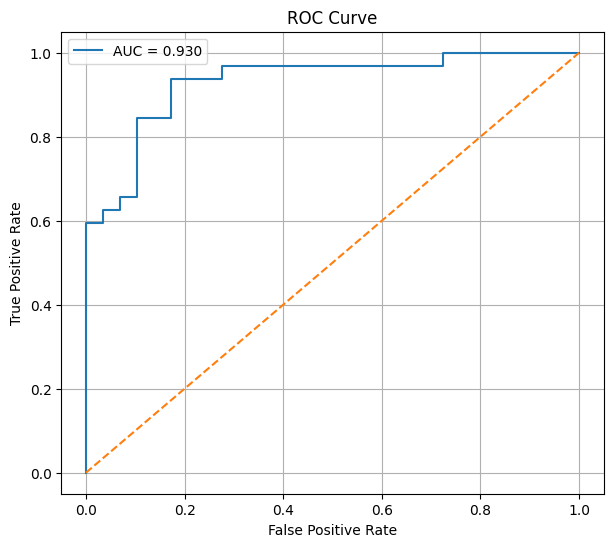

Cross Validation Mean Accuracy: 0.8380645161290323
Cross Validation Scores: [0.80645161 0.77419355 0.83333333 0.96666667 0.9        0.86666667
 0.86666667 0.8        0.7        0.86666667]
Accuracy: 0.8524590163934426

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.86      0.85        29
           1       0.87      0.84      0.86        32

    accuracy                           0.85        61
   macro avg       0.85      0.85      0.85        61
weighted avg       0.85      0.85      0.85        61

   sex  cp  fbs  restecg  exang  slope  ca  thal  age  trestbps  chol  \
0    1   3    1        0      0      0   0     1    2         2     1   
1    1   2    0        1      0      0   0     2    0         1     2   
2    0   1    0        0      0      2   0     2    1         1     1   
3    1   1    0        1      0      2   0     2    2         1     1   
4    0   0    0        1      1      2   0     2    2         1  

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc, classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns

#load dataset
df = pd.read_csv('../DataSets/heart.csv')
print("Original shape:", df.shape)
#drop duplicates
df.drop_duplicates(inplace=True)
print("After dropping duplicates:", df.shape)


# Handle outliers (replace with NaN)
numeric_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
def replace_outliers_with_nulls(data, columns):
    df_copy = data.copy()
    for col in columns:
        Q1 = df_copy[col].quantile(0.25)
        Q3 = df_copy[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_limit = Q1 - 1.5 * IQR
        upper_limit = Q3 + 1.5 * IQR
        df_copy.loc[(df_copy[col] < lower_limit) | (df_copy[col] > upper_limit), col] = np.nan
    return df_copy

df = replace_outliers_with_nulls(df, numeric_cols)
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

# Fill categorical NaNs with mode
categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
df[categorical_cols] = df[categorical_cols].fillna(df[categorical_cols].mode().iloc[0])

# Discretize numerical columns depend on medical research
df['age'] = pd.cut(df['age'], bins=[28, 39, 54, 64, 77],
                   labels=['young', 'middle', 'older', 'senior'], include_lowest=True)
df['trestbps'] = pd.cut(df['trestbps'], bins=[93, 119, 139, 159, 200],
                        labels=['low', 'borderline', 'high', 'very_high'])
df['chol'] = pd.cut(df['chol'], bins=[125, 199, 239, 564],
                    labels=['desirable', 'borderline', 'high'])
df['thalach'] = pd.cut(df['thalach'], bins=[70, 100, 140, 180, 202],
                       labels=['low', 'medium', 'high', 'very_high'])
df['oldpeak'] = pd.cut(df['oldpeak'], bins=[0, 1, 2, 3, 6.2],
                       labels=['normal', 'mild', 'moderate', 'severe'], include_lowest=True)

final_features = categorical_cols + ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
X = df[final_features].apply(lambda col: col.astype('category').cat.codes)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = CategoricalNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
sensitivity = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cm.ravel()
specificity = TN / (TN + FP)
roc_auc = auc(*roc_curve(y_test, y_prob)[:2])

# Results table
results_table = pd.DataFrame({
    "Metric": ["Accuracy", "Sensitivity (Recall)", "Precision", "F1 Score", "Specificity", "AUC Score"],
    "Value": [accuracy, sensitivity, precision, f1, specificity, roc_auc]
})
print("\n=== Model Evaluation Metrics ===")
print(results_table.to_string(index=False))

# Confusion Matrix Heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# Cross-validation
cv_scores = cross_val_score(model, X, y, cv=10)
print("Cross Validation Mean Accuracy:", cv_scores.mean())
print("Cross Validation Scores:", cv_scores)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print(X.head())
